# Analýza časových řad

V této lekci se podíváme na to, jak analyzovat časové řady. Na pomoc si pro tento účel vezmeme data s údaji o počasí (teplota, tlak apod.).

Abychom s daty mohli efektivně pracovat, budeme muset data ještě transformovat a pročistit. To je (bohužel) běžnou součástí datové analýzy, protože zdrojová data jsou typicky ne zcela vhodně uspořádána a často obsahují i chyby. Při práci s časovými řadami využijeme bohaté možnosti `pandas` pro práci s časovými údaji.

V této lekci se naučíš:
* načítat data ze souborů ve formátu Excel,
* efektivně čistit a transformat data na "spořádaná data".

## Načtení knihoven

Budeme používat samozřejmě `pandas`, pro vizualizaci pak `matplotlib` a `seaborn`.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

## Příprava dat

### Načtení hrubých dat - počasí

Naší základní datovou sadou budou data o počasí, konkrétně v Praze-Ruzyni. Data poskytuje Českým hydrometeorologický ústav (ČHMÚ) ve formě Excel souborů, dostupných z http://portal.chmi.cz/historicka-data/pocasi/denni-data. 

Možná překvapivě není úplně snadné dobrá a podrobná data získat. Ta nejkvalitnější jsou placená, navíc ["Česká data o počasí patří k nejdražším"](https://www.irozhlas.cz/zpravy-domov/data-statni-spravy-otevrena-data-chmu_1809140600_hm). Jen nedávno soud nařídil poskytovat alespoň základní data zdarma, viz [článek na irozhlas](https://www.irozhlas.cz/zpravy-domov/chmu-soud-pocasi-zaznamy_1807030700_cib).

Takto vypadají náhledy dvou listů ze souboru `P1PRUZ01.xls`, který obsahuje historická data z meteorologických měření v Praze-Ruzyni. Data jsou poměrně nepěkně uspořádána. Ani v Excelu by se s těmito soubory nepracovalo dobře...

![thumb_geografie.png](static/thumb_geografie.png)

![thumb_teplota.png](static/thumb_teplota.png)

Samotné načtení souboru je poměrně snadné. Použijeme na to třídu `ExcelFile`, protože kromě načítání poskytuje také property `sheet_names`.

Často stačí (a je jednodušší) použít funkci [`read_excel`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html#pandas.read_excel). V dokumentaci si všimni velkého množství argumentů, které umožňují správně načíst všelijak formátované soubory a hodnoty v nich. 

In [4]:
RUZYNE_DATA_FILENAME = "P1PRUZ01.xls"
RUZYNE_DATA_URL = "https://data4pydata.s3-eu-west-1.amazonaws.com/pyladies/P1PRUZ01.xls"

In [5]:
# stáhne data pokud ještě nejsou k dispozici
import os
import urllib.request

def save_file_from_url(url, target_filename):
    if not os.path.isfile(target_filename):
        print("Stahuji data - počkej chvíli ...")
        urllib.request.urlretrieve(url, target_filename)
    print(f"Data jsou v souboru {target_filename}")

In [6]:
save_file_from_url(RUZYNE_DATA_URL, RUZYNE_DATA_FILENAME)

Data jsou v souboru P1PRUZ01.xls


In [7]:
# otevření Excel souboru
excel_data_ruzyne = pd.ExcelFile(RUZYNE_DATA_FILENAME)

Zobrazíme si seznam listů v souboru.

In [8]:
excel_data_ruzyne.sheet_names

['geografie stanice',
 'teplota průměrná',
 'teplota maximální',
 'teplota minimální',
 'rychlost větru',
 'tlak vzduchu',
 'vlhkost vzduchu',
 'úhrn srážek',
 'celková výška sněhu',
 'sluneční svit']

Zatím jsme žádná data nenačetli (nemáme žádný `DataFrame` s daty ze souboru). Data načte ve formě `DataFrame` až metoda [`parse`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.ExcelFile.parse.html#pandas.ExcelFile.parse).

In [9]:
# načti data z jednoho listu a zobraz prvních 5
teplota_prumerna = excel_data_ruzyne.parse("teplota průměrná")
teplota_prumerna.head(5)

,Průměrná denní teplota vzduchu ve °C,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,stanice: P1PRUZ01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rok,měsíc,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0
3,1961,01,-2.0,-1.9,0.1,-0.3,0.4,-0.3,0.8,1.0,...,-2.4,-3.4,-3.9,-7.4,-9.8,-10.3,-9.0,0.7,4.7,4.7
4,1961,02,1.3,1.2,0.5,0.7,-3.3,0.6,3.1,2.3,...,2.8,3.0,3.4,0.9,2.6,4.4,5.8,NaN,NaN,NaN


Výsledek není přesně to, co bychom chtěli. Náprava je ale naštěstí jednoduchá - potřebujeme jen přeskočit první tři řádky. K tomu stačí přidat `skiprows=3`.

In [10]:
teplota_prumerna = excel_data_ruzyne.parse("teplota průměrná", skiprows=3)
teplota_prumerna.head(5)

,rok,měsíc,1.,2.,3.,4.,5.,6.,7.,8.,...,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.
0,1961,1,-2.0,-1.9,0.1,-0.3,0.4,-0.3,0.8,1.0,...,-2.4,-3.4,-3.9,-7.4,-9.8,-10.3,-9.0,0.7,4.7,4.7
1,1961,2,1.3,1.2,0.5,0.7,-3.3,0.6,3.1,2.3,...,2.8,3.0,3.4,0.9,2.6,4.4,5.8,NaN,NaN,NaN
2,1961,3,2.1,3.9,4.4,3.1,5.7,4.7,7.2,6.8,...,0.5,5.2,7.1,6.6,10.1,3.5,1.3,4.7,7.4,4.8
3,1961,4,8.1,8.4,7.8,10.0,13.5,16.2,17.0,10.6,...,13.5,10.9,11.7,11.0,12.4,10.9,11.4,11.4,12.5,NaN
4,1961,5,10.3,12.4,11.8,12.1,16.2,14.3,11.8,8.3,...,11.8,13.6,14.6,16.3,15.8,12.3,6.2,6.7,8.3,13.2


Tohle vypadá už trochu lépe - řádky a sloupce jsou tak, jak bylo zamýšleno. Problémem ale je, že dny jsou jako sloupce. Už jen proto, že ne každý měsíc má 31 dní. Proto se v posledních třech sloupcích vyskytují nedefinované hodnoty neboli `NaN` (Not a Number).

Chybějící hodnoty se mohou vyskytnout i z jiných důvodů než "jen" kvůli nevhodnosti uspořádání dat. Např. měřící přístroj mohl mít závadu, data se poškodila apod. Pro chybějící hodnoty mohou být použity různé zkratky a symboly a právě proto existuje šikovný argument `na_values`.

Z mnoha dobrých důvodů, které samy/i uvidíte v praxi, je naším cílem dostat data do podoby tzv. [*tidy data*](https://en.wikipedia.org/wiki/Tidy_data), kdy **řádky odpovídají jednotlivým pozorováním (měřením), názvy sloupců odpovídají veličinám.** 

Tady přijde vhod metoda [`melt`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html#pandas.DataFrame.melt). Ta slouží právě pro případy, kdy hodnoty jsou zakódované jako názvy sloupců. Takto vysvětlíme `melt`, že sloupce `["rok", "měsíc"]` jsou už správně jako "veličiny", že v názvech zbývajících sloupců jsou hodnoty veličiny `den` a že hodnoty patří veličině `teplota průměrná`, což se použije pro pojmenování nového sloupce. 

In [11]:
teplota_prumerna_tidy = teplota_prumerna.melt(
    id_vars=["rok", "měsíc"], var_name="den", value_name="teplota průměrná"
)
teplota_prumerna_tidy.head(5)

,rok,měsíc,den,teplota průměrná
0,1961,1,1.,-2.0
1,1961,2,1.,1.3
2,1961,3,1.,2.1
3,1961,4,1.,8.1
4,1961,5,1.,10.3


V tomto případě bylo celkem jasné, že názvy sloupců jsou vlastně hodnoty nějaké veličiny. Někdy to může být více skryté, např. v případě kategorických proměnných. Třeba data z měření délky nohou můžeme dostat v tomto formátu:

In [12]:
leg_length = pd.DataFrame({"left": [81, 81.4], "right": [78.2, 78]})
leg_length

,left,right
0,81.0,78.2
1,81.4,78.0


**Úkol:** Má `leg_length` podobu tidy data? Pokud ne, dokážeš tato data uspořádat správně?

### Vytvoření "správného" (časového) indexu

Téměř nikdy nechceme pracovat s oddělenými sloupci "rok", "měsíc" apod. Práci s časovými údaji a časovými řadami mají na starosti specializované třídy, především [`Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html#pandas.Timestamp) a [`DatetimeIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html), pro rozdíly mezi časovými údaji pak [Timedelta](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html#pandas.Timedelta). Přehled najdeš v dokumentaci: [Time series / date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html). A věřte - není to jednoduchý problém. Časová algebra pracuje zároveň s desítkovou, šedesátkovou, dvanáctkovou, dvacetčtyřkovou, sedmičkovou, měsíční, kvartální, roční, ... algebrou. Do toho vstupují časové zóny, přestupné roky, letní čas, různé kalendáře a kdo ví co ještě. 

Pojďme tedy vytvořit pro naši časovou řadu ten "správný" časový index. K tomu se často se hodí funkce [`to_datetime`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html#pandas.to_datetime). Tato funkce umí převádět numerické nebo textové údaje (jednotlivě i celé řady) do toho správného Pandas typu pro práci s časovými údaji. 

Pro nás se hodí, že umí pracovat i s daty, kde jsou v oddělených sloupcích roky, měsíce, dny atd. Ukážeme si to na na jednoduchém příkladu.

In [13]:
# příklad řady datumů v oddělených sloupcích
split_dates_example = pd.DataFrame(
    {"year": [2015, 2016], "month": [2, 3], "day": [4, 5]}
)
split_dates_example

,year,month,day
0,2015,2,4
1,2016,3,5


Funkce `to_datetime` nám z ukázkové tabulky vytvoří řadu (`Series`) typu `datetime64[ns]`. Tento (numpy) typ podporuje mnoho užitečných metod pro práci s časovými údaji, viz. [Datetimes and Timedeltas](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html). Údaj `[ns]` ukazuje na (výchozí) nanosekundovou přesnost. 

In [14]:
pd.to_datetime(split_dates_example)

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

Aby to fungovalo na naše česká data, je potřeba jen přejmenovat sloupce "rok", "měsíc", "den" na "year", "month", "day". K tomu máme metodu `rename`, tak to pojďme vyzkoušet rovnou dohromady. Výsledek uložíme do nové proměnné `datum`.

In [15]:
datum = pd.to_datetime(
        teplota_prumerna_tidy[["rok", "měsíc", "den"]].rename(
            columns={"rok": "year", "měsíc": "month", "den": "day"}
        ),
    )

ValueError: cannot assemble the datetimes: day is out of range for month

Skoro - skončilo to poměrně logickou chybou (výjimkou) `ValueError: cannot assemble the datetimes: day is out of range for month`. Nepovedlo se (naštěstí) přesvědčit `pandas`, že všechny měsíce mají 31 dní :)

Pomocí `errors="coerce"` ale můžeme nařídit, aby se převedla všechna správná data a chybná data se označila jako `NaN`, resp. v tomto případě `NaT` - Not a Time. 

In [16]:
datum = pd.to_datetime(
    teplota_prumerna_tidy[["rok", "měsíc", "den"]].rename(
        columns={"rok": "year", "měsíc": "month", "den": "day"}
    ),
    errors="coerce",
)

In [17]:
datum

0       1961-01-01
1       1961-02-01
2       1961-03-01
3       1961-04-01
4       1961-05-01
           ...    
21571   2018-08-31
21572          NaT
21573   2018-10-31
21574          NaT
21575   2018-12-31
Length: 21576, dtype: datetime64[ns]

Pro úplnou informaci o čase bychom měli ještě přidat údaj o časové zóně. To nám umožní správně časy porovnávat, nebo třeba zachytit letní a zimní čas, což je často dosti svízelný problém. V našem případě denních dat to sice není zcela zásadní, v některých případech se to ale projevit může.

U časových údajů, které neobsahují časovou zónu, můžeme použít [`.dt.tz_localize`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.tz_localize.html#pandas.Series.tz_localize). Pro konverzi časové zóny pak slouží [`.dt.tz_convert`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tz_convert.html#pandas.DataFrame.tz_convert).

[`.dt`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html#pandas.Series.dt) je tzv. *accessor object* pro práci s časovými vlastnostmi dat.

In [18]:
datum_localized = datum.dt.tz_localize("Europe/Prague")
datum_localized

0       1961-01-01 00:00:00+01:00
1       1961-02-01 00:00:00+01:00
2       1961-03-01 00:00:00+01:00
3       1961-04-01 00:00:00+01:00
4       1961-05-01 00:00:00+01:00
                   ...           
21571   2018-08-31 00:00:00+02:00
21572                         NaT
21573   2018-10-31 00:00:00+01:00
21574                         NaT
21575   2018-12-31 00:00:00+01:00
Length: 21576, dtype: datetime64[ns, Europe/Prague]

Určitě jste si všimli, že přibyl i údaj o čase, a samozřejmě o časové zóně a tím i o posunu od [UTC](https://cs.wikipedia.org/wiki/Koordinovan%C3%BD_sv%C4%9Btov%C3%BD_%C4%8Das). `+01:00` znamená +1 hodina od UTC. U datumů je totiž koncept časové zóny ne úplně přirozený a proto Pandas přidal i čas (`00:00:00`). Jelikož je ale často význam denních dat nějaký souhrn za konkrétních 24 hodin (a někdy za 23 hodin a někdy za 25 hodin díky střídaní letního a zimního času), je lepší pracovat i konkrétním časem (začátkem dne). A to je i náš případ.

Teď už jen pomocí `assign` přidáme sloupec "datum". Můžeš ověřit, že následná analýza bude fungovat i s lokalizovaným časem `datum_localized`.

In [19]:
teplota_prumerna_tidy = teplota_prumerna_tidy.assign(datum=datum)
teplota_prumerna_tidy

,rok,měsíc,den,teplota průměrná,datum
0,1961,1,1.,-2.0,1961-01-01
1,1961,2,1.,1.3,1961-02-01
2,1961,3,1.,2.1,1961-03-01
3,1961,4,1.,8.1,1961-04-01
4,1961,5,1.,10.3,1961-05-01
...,...,...,...,...,...
21571,2018,8,31.,15.7,2018-08-31
21572,2018,9,31.,NaN,NaT
21573,2018,10,31.,7.8,2018-10-31
21574,2018,11,31.,NaN,NaT


**Úkol:** `to_datetime` dokáže pracovat i s řetězci, což se často hodí. Převeďte `ladies_times` na vohodný typ pro časové údaje, přiřaďte naši časovou zónu a poté pomocí `tz_convert` převeďte na UTC. Možná budete muset pandám vysvětlit, že v Česku jsou v datumech nejdříve dny, na rozdíl třeba od Ameriky. Naštěstí na to stačí jeden jednoduchý argument pro `to_datetime`.

In [ ]:
ladies_times = ["23. 1. 2020 18:00", "30. 1. 2020 18:00", "6. 2. 2020 18:00"]

In [ ]:
pandas_times = pd.to_datetime(___).___.___

### Čištění dat

Co se stalo s nedefinovanými hodnotami? Zůstaly tam. Pojďme se podívat, jak to vlastně zjistit a co se s tím dá dělat.

Obecně máme tři základní možnosti.

1. Nedělat nic, tj. nechat chybějící data chybět. To je možná překvapivě často dobrá volba, protože mnoho funkcí si s chybějícími daty poradí správně. To je rozdíl oproti `numpy`, kde funkce typicky `NaN` nemají rády. Často existují varianty funkcí (např. `numpy.mean` -> `numpy.nanmean`), které `NaN` berou jako chybějící data. 

2. Pozorování (tj. řádky, protože máme tidy data) s chybějícími záznamy vynechat. K tomu slouží metoda [`dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna).

3. Chybějící data nahradit nějakou vhodnou hodnotou. Co jsou vhodné hodnoty, záleží na povaze dat a na tom, co s daty dále děláme. Někdy je vhodné nahradit chybějící hodnoty nějakou "typickou" hodnotou, třeba průměrem. Pro časové řady je většinou logičtější nahradit hodnotou z okolí (předchozí nebo následující). O nahrazování typickými hodnotami (angl. imputation) se dočteš https://scikit-learn.org/stable/modules/impute.html a možná dozvíš víc i později. K nahrazování hodnotami z okolí pak slouží metoda [`fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna).

Pro naše účely se bude nejvíce hodit vynechat chybějící záznamy, které vznikly nehezkým uspořádáním Excel souboru.

Nejprve bychom ale měli zjistit, kde přesně ty chybějící hodnoty jsou. Metoda [`isna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html#pandas.DataFrame.isna) nám dokáže "najít" nedefinované hodnoty:

In [20]:
teplota_prumerna_tidy.isna()

,rok,měsíc,den,teplota průměrná,datum
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
21571,False,False,False,False,False
21572,False,False,False,True,True
21573,False,False,False,False,False
21574,False,False,False,True,True


Použití `sum` na `True` a `False` je užitečný trik, `True` se počítá jako 1, `False` jako 0.

In [21]:
teplota_prumerna_tidy.isna().sum()

rok                   0
měsíc                 0
den                   0
teplota průměrná    392
datum               392
dtype: int64

Vidíme tedy, že ve sloupcích s teplotou a datumem je 392 nedefinovaných hodnot.

Můžeme si také zobrazit výběr řádků, kde je alespoň nějaký `NaN`. Jistě si pamatuješ, že indexovat lze pomocí řady typu `bool`. Drobný problém je, že máme těch řad víc - pro každý sloupec jednu. Můžeme ale použít `.any(axis=1)`, abychom vybrali řádky, kde je alespoň nějaký `NaN`: 

In [22]:
teplota_prumerna_tidy.loc[teplota_prumerna_tidy.isna().any(axis=1)].sample(5)

,rok,měsíc,den,teplota průměrná,datum
21267,1993,4,31.,NaN,NaT
21385,2003,2,31.,NaN,NaT
20173,2018,2,29.,NaN,NaT
21245,1991,6,31.,NaN,NaT
20113,2013,2,29.,NaN,NaT


Způsobem, jak získat naopak počet nechybějících (platných) hodnot, je metoda `count`

In [23]:
teplota_prumerna_tidy.count()

rok                 21576
měsíc               21576
den                 21576
teplota průměrná    21184
datum               21184
dtype: int64

**Otázka:** Co vrátí `teplota_prumerna_tidy.isna().count()`?

Teď už ale ta chybějící data chceme odstranit. Podívejme se na jednoduchém příkladu, jak funguje [`dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna).

In [24]:
# příklad dat s chybějícími hodnotami
example_with_nan = pd.DataFrame({"A": [1, 2, np.nan, 4, 5], "B": [1, 2, 3, np.nan, 5]})
example_with_nan

,A,B
0,1.0,1.0
1,2.0,2.0
2,NaN,3.0
3,4.0,NaN
4,5.0,5.0


Po `dropna` zbudou pouze řádky bez chybějících hodnot.

In [25]:
example_with_nan.dropna()

,A,B
0,1.0,1.0
1,2.0,2.0
4,5.0,5.0


Tohle přesně potřebujeme na naše data, která teď vyčistíme od nedefinovaných hodnot:

In [26]:
teplota_prumerna_tidy_clean = teplota_prumerna_tidy.dropna()

**Úkol:** Zařaďte `dropna` do sestrojení datumů tak, abychom nemuseli použít `errors="coerce"` pro `to_datetime`.

In [ ]:
# přidejte dropna
pd.to_datetime(
    teplota_prumerna_tidy[["rok", "měsíc", "den"]].rename(
        columns={"rok": "year", "měsíc": "month", "den": "day"}
    ),
)

**Úkol**: Vytvořte `teplota_prumerna_tidy_clean_indexed` se sloupcem `datum` jako indexem a bez sloupců `rok`, `měsíc` a `den`. Můžete použít metodu `drop`.

In [ ]:
teplota_prumerna_tidy_clean_indexed = ___

### Vše dohromady 

Parsování celého souboru, tj. jeho načtení a převedení do požadované formy Pandas `DataFrame`, máme teď hotové. Pro další generace (a naše použití) na to definujeme funkci. V rámci této funkce také vyhodíme sloupce rok, měsíc a den, sloupec datum použijeme jako index a data podle datumu setřídíme. Přidali jsme ještě jméno listu jako vstupní parameter, což se bude hodit hned vzápětí pro načítání všech listů do jednoho `DataFrame`.

In [27]:
def extract_and_clean_chmi_excel_sheet(excel_data, sheet_name):
    """Parse ČHMÚ historical meteo excel data"""
    # načti list z excel souboru a převeď na tidy data formát
    data_tidy = (
        excel_data.parse(sheet_name, skiprows=3)
        .melt(id_vars=["rok", "měsíc"], var_name="den", value_name=sheet_name)
        .dropna()
    )
    # vytvoř časovou řadu datumů
    datum = pd.to_datetime(
        data_tidy[["rok", "měsíc", "den"]].rename(
            columns={"rok": "year", "měsíc": "month", "den": "day"}
        )
    )
    # přidej sloupec datum jako index a odstraň den, měsíc, rok a vrať setříděný výsledek
    return (
        data_tidy.assign(datum=datum)
        .set_index("datum")
        .drop(columns=["rok", "měsíc", "den"])
        .sort_index()
    )

A teď už si můžeme načíst všechna data z Ruzyně tak, jak se nám budou hodit pro analýzu.

In [28]:
# otevři Excel soubor
excel_data_ruzyne = pd.ExcelFile("P1PRUZ01.xls")
# načti všechny listy kromě prvního
extracted_sheets = (
    extract_and_clean_chmi_excel_sheet(excel_data_ruzyne, sheet_name)
    for sheet_name in excel_data_ruzyne.sheet_names[1:]
)
# spoj všechny listy do jednoho DataFrame
ruzyne_tidy = pd.concat(extracted_sheets, axis=1)

U použití `concat` je důležité, že všecha data mají stejný index. `axis=1` říká, že se mají skládat sloupce vedle sebe. Výchozí `axis=0` by spojovala data pod sebe a nedopadlo by to úplně dobře (můžeš vyzkoušet :)). Detailněji jsme to řešili v lekci o nulových hodnotách a odlehlých pozorováních.

Prohlédneme si výslednou tabulku `ruzyne_tidy`.

In [29]:
ruzyne_tidy

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
datum,,,,,,,,,
1961-01-01,-2.0,1.0,-3.4,1.7,969.9,87.0,0.0,6.0,0.4
1961-01-02,-1.9,-1.2,-2.4,3.0,965.2,89.0,0.0,4.0,0.0
1961-01-03,0.1,1.0,-2.6,2.7,952.3,80.0,0.0,3.0,0.0
1961-01-04,-0.3,2.1,-2.0,3.3,953.6,87.0,0.0,3.0,1.0
1961-01-05,0.4,2.8,-4.3,6.3,963.9,81.0,0.0,2.0,2.2
...,...,...,...,...,...,...,...,...,...
2018-12-27,4.0,6.5,2.7,5.4,981.4,88.0,0.0,0.0,0.5
2018-12-28,3.9,6.2,0.3,3.9,981.5,82.0,0.0,0.0,3.9
2018-12-29,2.2,4.8,1.3,5.8,983.8,87.0,0.8,0.0,0.5


## Indexování a výběr intervalů

Data, která jsme načetli a vyčistili, tvoří vlastně několik časových řad v jednotlivých sloupcích tabulky `ruzyne_tidy`. Granularita (nebo frekvence či časové rozlišení) je jeden den.

Pomocí `to_period()` bychom mohli datový typ indexu převést i na `period[D]`. To může zrychlit některé operace, pro naše použití to ale není nezbytné.

In [30]:
ruzyne_tidy.index.to_period()

PeriodIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
             '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
             '1961-01-09', '1961-01-10',
             ...
             '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
             '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
             '2018-12-30', '2018-12-31'],
            dtype='period[D]', name='datum', length=21184, freq='D')

Už jsme si ukazovali indexování (výběr intervalu) pomocí `.loc`. U časových řad to funguje samozřejmě také. Pozor na to, že `.loc` vrací data *včetně* horní meze, *na rozdíl* od indexování `list`ů nebo numpy polí. 

Konkrétní období můžeme vybrat třeba takto:

In [31]:
ruzyne_tidy.loc[pd.Timestamp(2017, 12, 24) : pd.Timestamp(2018, 1, 1)]

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
datum,,,,,,,,,
2017-12-24,6.1,7.0,5.5,7.7,979.5,82.0,0.0,0.0,0.3
2017-12-25,1.7,5.7,-0.6,4.0,975.4,88.0,0.0,0.0,0.0
2017-12-26,1.2,4.5,-4.5,3.7,964.1,85.0,0.0,0.0,1.6
2017-12-27,-0.7,3.4,-3.5,2.7,949.1,91.0,2.2,0.0,0.8
2017-12-28,1.0,1.5,-0.8,5.7,951.8,87.0,7.0,0.0,0.0
2017-12-29,-1.7,1.2,-3.8,6.3,965.0,79.0,0.1,1.0,1.9
2017-12-30,2.5,4.8,-3.8,5.7,962.7,86.0,1.8,1.0,0.2
2017-12-31,9.1,11.5,4.5,6.7,964.6,81.0,0.5,0.0,1.2
2018-01-01,4.1,9.1,0.4,4.7,962.9,77.0,0.0,0.0,0.4


### Atributy časových proměnných

Časové proměnné typu [`DatetimeIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) poskytují velice užitečnou sadu atributů vracející
* části časového údaje, např. `.year` vrátí pouze rok, `.month` měsíc apod., 
* relativní informace , např. `.weekday` nebo `.weekofyear`
* kalendářní vlastnosti jako `is_quarter_start` nebo `is_year_end`, které by bylo poměrně náročné zjišťovat numericky.

In [32]:
ruzyne_tidy.index.year

Int64Index([1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961,
            ...
            2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018],
           dtype='int64', name='datum', length=21184)

Můžeme tak vybrat jeden celý rok např. takto:

In [33]:
ruzyne_tidy.loc[ruzyne_tidy.index.year == 2018]

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
datum,,,,,,,,,
2018-01-01,4.1,9.1,0.4,4.7,962.9,77.0,0.0,0.0,0.4
2018-01-02,3.9,5.7,0.5,6.9,965.8,81.0,1.0,0.0,0.5
2018-01-03,4.6,7.6,0.5,9.3,952.9,81.0,7.9,0.0,0.8
2018-01-04,4.5,5.7,3.9,5.9,955.9,82.0,0.9,0.0,0.5
2018-01-05,7.3,9.0,4.1,5.6,958.5,80.0,0.3,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2018-12-27,4.0,6.5,2.7,5.4,981.4,88.0,0.0,0.0,0.5
2018-12-28,3.9,6.2,0.3,3.9,981.5,82.0,0.0,0.0,3.9
2018-12-29,2.2,4.8,1.3,5.8,983.8,87.0,0.8,0.0,0.5


Nebo můžeme získat data pro všechny dny před rokem 1989, které jsou začátky kvartálů a zároveň to jsou pondělky.

In [34]:
ruzyne_tidy.loc[
    ruzyne_tidy.index.is_quarter_start
    & (ruzyne_tidy.index.weekday == 0)
    & (ruzyne_tidy.index.year < 1989)
]

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
datum,,,,,,,,,
1962-01-01,0.2,2.4,-4.0,4.3,966.5,75.0,0.0,1.0,0.0
1962-10-01,15.6,22.4,8.3,1.7,976.6,73.0,0.0,0.0,8.8
1963-04-01,1.0,2.9,0.6,2.7,971.9,96.0,1.3,0.0,0.0
1963-07-01,17.3,21.2,15.4,2.0,972.1,79.0,0.0,0.0,1.0
1968-01-01,-4.1,0.4,-6.5,4.0,958.0,82.0,0.4,1.0,0.0
1968-04-01,8.5,17.6,0.2,4.3,973.0,55.0,0.0,0.0,11.8
1968-07-01,20.9,25.9,11.3,3.7,980.8,62.0,0.0,0.0,14.3
1973-01-01,-2.1,3.8,-9.2,3.3,983.5,57.0,0.0,0.0,6.3
1973-10-01,9.7,12.8,6.2,1.3,977.7,74.0,0.0,0.0,0.0


**Úkol:** Jaká byla průměrná teplota první (a jedinou) neděli v roce 2010, která byla zároveň začátkem měsíce? Pokud máte řešení a čas, zkuste vymyslet aternativní způsob(y). 

In [ ]:
ruzyne_tidy.loc[
    ___
    & (___)
    & (___),
    "teplota průměrná",
]

## Práce s časovou řadou

Pojďme trochu zkombinovat statistiku a práci s časovou řadou. Zajímalo by vás, jak moc byl který rok teplý či studený? Pomocí [`resample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html#pandas.DataFrame.resample) můžeme změnit rozlišení dat na jiné období, např. jeden rok.

In [35]:
ruzyne_yearly = ruzyne_tidy.resample("1Y")

Co že jsme to vlastně vytvořili?

In [36]:
ruzyne_yearly

Dostali jsme instanci třídy `DatetimeIndexResampler`. To zní logicky, ale kde jsou data? Ta zatím nejsou, protože jsme ještě `pandas` neřekli, jak vlastně mají ze všech těch denních údajů v rámci jednoho roku vytvořit ta roční data. Neboli, jak data *agregovat*.

Ze statistiky víme, že jedním z ukazatelů může být střední hodnota. Zkusíme vypočítat průměrnou "teplotu průměrnou" (není to překlep) a rovnou vykreslit.

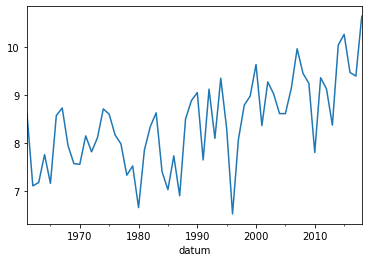

In [37]:
ruzyne_yearly["teplota průměrná"].mean().plot();

Trochu podobnou operací jako resampling je rolování. To spočívá v plynulém posouvání "okna", které slouží pro (vážený) výběr dat a následné aplikaci agregační funkce (jako u `resample`). Pojďme pomocí [`rolling`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html#pandas.DataFrame.rolling) vytvořit podobný pohled na roční průměrnou teplotu. Rozdíl oproti `resample` je v tom, že dostaneme pro každý den jednu hodnotu, nikoli jen jednu hodnotu pro celý rok. A také už nemůžeme použít interval `"1Y"`, protože jeden (kalendářní) rok není dobře definovaný interval díky přestupným rokům.

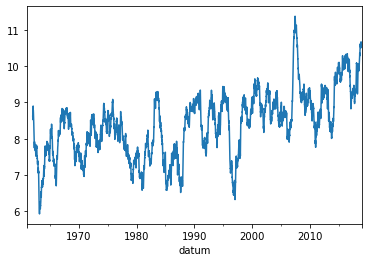

In [38]:
ruzyne_tidy["teplota průměrná"].rolling("365.25D", min_periods=365).mean().plot();

Pro podrobnější přehled práce s časovými řadami se podívejta např. na https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html nebo třeba na hezký článek s podobnými daty https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/.

**Úkol:** Navrhněte vhodnou agregaci pro maximální teplotu (ne průměr) a vykreslete.

In [ ]:
ruzyne_yearly[___].___().___();

**Úkol:** Převzorkujte údaje za rok 2018 po měsících. Jaký měsíc měl nejvíc srážek, tj. za jaký byl součet sloupce "úhrn srážek" nejvyšší?

In [ ]:
# doplňte nebo vyřešte po svém :)
ruzyne_tidy.loc[___ == 2018, "úhrn srážek"].___(
    "1M"
).___().___(ascending=False).index[___].___